In [1]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import the datasets
november = pd.read_csv('./november.csv.gz')
december = pd.read_csv('./december.csv.gz')

In [3]:
# merge two datasets
events = pd.concat([november, december], axis=0, ignore_index=True)

###  Data exploring

In [4]:
events.shape

(7033125, 9)

#### Previous conclusion: Over 7 millions events in our datasets

In [5]:
# check the missing values for each feature
events.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code         0
brand            395108
price                 0
user_id               0
user_session         27
dtype: int64

In [6]:
events.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:14 UTC,cart,1005014,2053013555631882655,electronics.smartphone,samsung,503.09,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a
1,2019-11-01 00:00:41 UTC,purchase,13200605,2053013557192163841,furniture.bedroom.bed,NaN,566.30,559368633,d6034fa2-41fb-4ac0-9051-55ea9fc9147a
2,2019-11-01 00:01:04 UTC,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.92,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d
3,2019-11-01 00:03:24 UTC,cart,1801881,2053013554415534427,electronics.video.tv,samsung,488.80,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e
4,2019-11-01 00:03:39 UTC,cart,1005115,2053013555631882655,electronics.smartphone,apple,949.47,565865924,fd4bd6d4-bd14-4fdc-9aff-bd41a594f82e


In [7]:
events["event_time"] = pd.to_datetime(events["event_time"], 
                                      format="%Y-%m-%d %H:%M:%S %Z")

In [8]:
events["event_time"]

0         2019-11-01 00:00:14+00:00
1         2019-11-01 00:00:41+00:00
2         2019-11-01 00:01:04+00:00
3         2019-11-01 00:03:24+00:00
4         2019-11-01 00:03:39+00:00
                     ...           
7033120   2019-12-31 23:57:10+00:00
7033121   2019-12-31 23:57:52+00:00
7033122   2019-12-31 23:58:28+00:00
7033123   2019-12-31 23:58:40+00:00
7033124   2019-12-31 23:59:09+00:00
Name: event_time, Length: 7033125, dtype: datetime64[ns, UTC]

In [9]:
# check if the data really for November and December
events["event_time"].agg(["min","max"])

min   2019-11-01 00:00:14+00:00
max   2019-12-31 23:59:09+00:00
Name: event_time, dtype: datetime64[ns, UTC]

In [10]:
# check if we have event data for every single date
events.assign(month=events["event_time"].dt.month,
              day=events["event_time"].dt.day).groupby("month")["day"].nunique()

month
11    30
12    31
Name: day, dtype: int64

#### Previous conclusion: Everyday in two months we have events

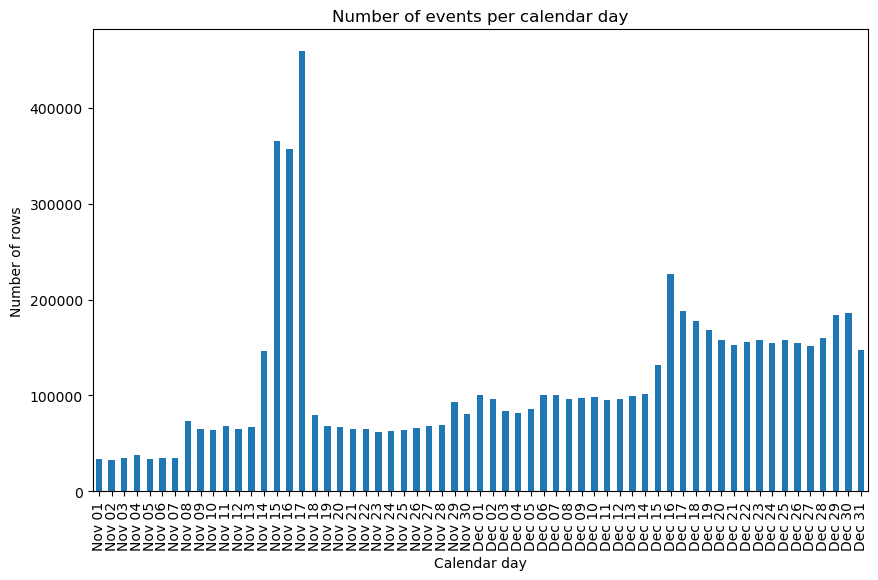

In [11]:
# The distrbuition of events acroos the days
fig, axis = plt.subplots(figsize=(10, 6))

events.assign(month=events["event_time"].dt.month,
              day=events["event_time"].dt.day).groupby(["month", "day"]).size().plot.bar(ax=axis)

labels = (
    pd.date_range(events["event_time"].dt.date.min(),
                  events["event_time"].dt.date.max(),
                  freq="D").strftime("%b %d"))

axis.set(title="Number of events per calendar day",
         xlabel="Calendar day",
         ylabel="Number of rows", xticklabels=labels)

plt.show()

In [12]:
# proportion of the different events (cart or purchase)
events["event_type"].value_counts(dropna=False)

event_type
cart        5276372
purchase    1756753
Name: count, dtype: int64

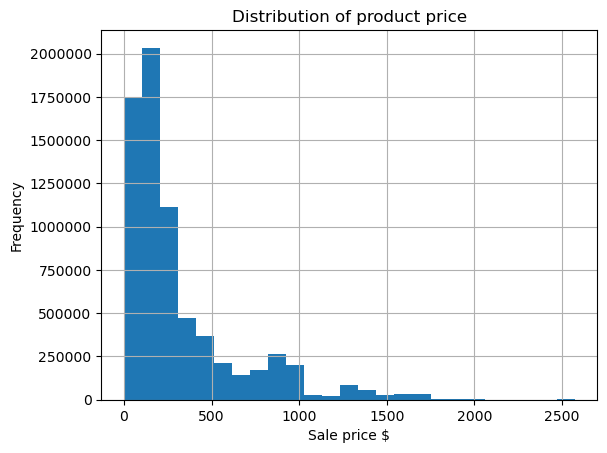

In [13]:
# distribution of product sale prices
fig, axis = plt.subplots()

events["price"].hist(bins=25, ax=axis)

# disable scientific notation
axis.ticklabel_format(useOffset=False, style="plain")

axis.set(title="Distribution of product price",
         xlabel="Sale price $",
         ylabel="Frequency")

plt.show()

#### Previous conclusion: Most of our products sold for under 500 with some outliers up to $2,500.

In [14]:
events["brand"].value_counts().head(10)  # top 10 brands in sales

brand
samsung    1756284
apple      1368364
xiaomi      722125
huawei      263155
oppo        128661
lg          123581
sony         78615
artel        72124
lucente      69998
lenovo       59700
Name: count, dtype: int64

In [23]:
# check if we have any product IDs that are assigned to multiple categories?

events.groupby("product_id")["category_code"].nunique().loc[lambda x: x > 1].sort_values(ascending=False)



product_id
1000978      2
13900087     2
13900049     2
13900054     2
13900055     2
            ..
5701183      2
5701186      2
5701190      2
5701192      2
100028003    2
Name: category_code, Length: 12884, dtype: int64

In [25]:
events["category_code"].value_counts().head(10)  # top 10 brands in our datasets

category_code
construction.tools.light            1823398
electronics.smartphone              1577185
electronics.audio.headphone          240308
electronics.clocks                   233198
sport.bicycle                        231644
apparel.shoes                        212586
appliances.kitchen.refrigerators     190523
appliances.personal.massager         185601
appliances.environment.vacuum        170290
appliances.kitchen.washer            170121
Name: count, dtype: int64

In [27]:
# what are brands assigned to category (construction.tools.light)?
events.loc[events["category_code"] == "construction.tools.light", "brand"].value_counts().head(10)

brand
samsung    727599
apple      521481
xiaomi     304546
huawei     149347
oppo        68446
vivo        10709
meizu        9093
honor        4389
nokia        3231
omron        3003
Name: count, dtype: int64

In [28]:
# store the product ids that assigned to more than one category
dupe_product_ids = events.groupby("product_id")["category_code"].nunique().loc[lambda x:x>1].index.values

In [29]:
dupe_product_ids[:10]

array([1000978, 1001588, 1001618, 1001619, 1002098, 1002100, 1002101,
       1002225, 1002367, 1002482], dtype=int64)

In [31]:
events.loc[events["product_id"] == 1001588, "category_code"].value_counts()

category_code
construction.tools.light    50
electronics.smartphone      22
Name: count, dtype: int64

In [32]:
# solution to fix the product ID has multiple categories problem

def get_correct_category_code(product_id_rows):
    # product_id_rows is all rows for a given product ID
    categories = product_id_rows["category_code"].value_counts()

    # if one is construction.tools.light, return the other one
    if "construction.tools.light" in categories.index:
        return categories.index.drop("construction.tools.light").values[0]
    else:
        return categories.index[0]  # return the majority category


corrected_categories = events[events["product_id"].isin(dupe_product_ids)].groupby("product_id").apply(get_correct_category_code).reset_index(name="corrected_category")


In [33]:
corrected_categories.head()

,product_id,corrected_category
0,1000978,electronics.smartphone
1,1001588,electronics.smartphone
2,1001618,electronics.smartphone
3,1001619,electronics.smartphone
4,1002098,electronics.smartphone


In [35]:
# merge the corrected categories into our events dataset
events = events.merge(corrected_categories, on="product_id", how="left")
# overwrite the categories where the original and the corrected categories do not match.
events.loc[events["corrected_category"].notnull(), "category_code"] = events.loc[events["corrected_category"].notnull(), "corrected_category"]

In [36]:
events["category_code"].value_counts()

category_code
electronics.smartphone              3350680
sport.bicycle                        384120
appliances.personal.massager         254300
electronics.clocks                   228546
appliances.kitchen.refrigerators     214637
                                     ...   
apparel.skirt                           261
construction.tools.soldering            200
sport.diving                            144
computers.components.sound_card         118
auto.accessories.light                   41
Name: count, Length: 134, dtype: int64

In [37]:
# make our category column from category code column to mention for just one category (without sub-categories)
events["category"] = events["category_code"].str.split(".").str[0]
# rename category_code column to subcategory
events = events.rename(columns={"category_code": "subcategory"})
events["category"].value_counts()

category
electronics     3908916
appliances      1250149
apparel          540955
sport            439029
computers        291790
furniture        216264
construction     144637
kids              98236
auto              89079
accessories       39350
country_yard       6106
medicine           5616
stationery         2998
Name: count, dtype: int64

In [38]:
events["subcategory"].value_counts()

subcategory
electronics.smartphone              3350680
sport.bicycle                        384120
appliances.personal.massager         254300
electronics.clocks                   228546
appliances.kitchen.refrigerators     214637
                                     ...   
apparel.skirt                           261
construction.tools.soldering            200
sport.diving                            144
computers.components.sound_card         118
auto.accessories.light                   41
Name: count, Length: 134, dtype: int64

#### Previous conclusion: We solved a problem where each product ID could have multiple categories assigned to it by assign it to the majority category

In [40]:
# check the products against brands
duplicated_brands = events.assign(brand=events["brand"].fillna("No brand"))\
.groupby("product_id")["brand"].nunique().loc[lambda x: x > 1].index

In [41]:
len(duplicated_brands)

1245

In [46]:
# investigating products labeled with multiple brands
duplicated_brands[:10]

Index([1001618, 1002310, 1002786, 1002877, 1003080, 1003224, 1003238, 1003330,
       1003604, 1003851],
      dtype='int64', name='product_id')

In [47]:
def get_correct_brand(product_id_rows):
    brand_counts = product_id_rows["brand"].value_counts(dropna=False)

    if isinstance(brand_counts.index[0], str):
        return brand_counts.index[0]  # return the majority brand

    if len(brand_counts) == 1:
        return np.nan
    
    # otherwise return the second value (the majority non-null value)
    return brand_counts.index[1]

In [48]:
corrected_brands = events[events["product_id"].isin(duplicated_brands)]\
.groupby("product_id").apply(get_correct_brand).reset_index(name="corrected_brand")

corrected_brands.head()

,product_id,corrected_brand
0,1001618,apple
1,1002310,lg
2,1002786,apple
3,1002877,samsung
4,1003080,huawei


In [49]:
events = events.merge(corrected_brands, on="product_id", how="left")

In [50]:
events.loc[events["corrected_brand"].notnull(), "brand"] = \
events.loc[events["corrected_brand"].notnull(), "corrected_brand"]

In [51]:
assert (len(events[["product_id", "category", "subcategory", "brand"]].drop_duplicates())\
        == events["product_id"].nunique())


#### Previous conclusion: We solved a problem where each product ID could have multiple brands assigned to it by assign it to the majority brand

In [53]:
def get_product_name(row):
    brand = ""
    # only include brand if it's available
    if isinstance(row["brand"], str):
        brand = row["brand"]
        
    return f"{str(row['product_id'])} - {brand} {row['subcategory']}"

# add a new product_name column
events["product_name"] = events.apply(get_product_name, axis=1)

In [54]:
events.head()

,event_time,event_type,product_id,category_id,subcategory,brand,price,user_id,user_session,corrected_category,category,corrected_brand,product_name
0,2019-11-01 00:00:14+00:00,cart,1005014,2053013555631882655,electronics.smartphone,samsung,503.09,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a,electronics.smartphone,electronics,NaN,1005014 - samsung electronics.smartphone
1,2019-11-01 00:00:41+00:00,purchase,13200605,2053013557192163841,furniture.bedroom.bed,NaN,566.30,559368633,d6034fa2-41fb-4ac0-9051-55ea9fc9147a,NaN,furniture,NaN,13200605 - furniture.bedroom.bed
2,2019-11-01 00:01:04+00:00,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.92,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d,electronics.smartphone,electronics,NaN,1005161 - xiaomi electronics.smartphone
3,2019-11-01 00:03:24+00:00,cart,1801881,2053013554415534427,appliances.personal.massager,samsung,488.80,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e,appliances.personal.massager,appliances,NaN,1801881 - samsung appliances.personal.massager
4,2019-11-01 00:03:39+00:00,cart,1005115,2053013555631882655,electronics.smartphone,apple,949.47,565865924,fd4bd6d4-bd14-4fdc-9aff-bd41a594f82e,electronics.smartphone,electronics,NaN,1005115 - apple electronics.smartphone


In [55]:
# export the modified dataset to a new intermidiate dataset
events.to_parquet("./events.parquet.gz", compression="gzip")